<a href="https://colab.research.google.com/github/asterixogaules/hello-world/blob/main/MVP_Analytics_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Sentimentos em Português Baseada em Revisão de Produtos

## Introdução

### Motivação

A interação homem-máquina em geral não é projetada para captar subjetividades referentes ao estado emocional do usuário. Entretanto, na prática, a emoção orienta significativamente o tipo de resposta esperada e, dessa forma, a naturalidade de uma interação conversacional compreensível ao ser-humano. Nesse sentido, para o desenvolvimento do Processamento de Linguagem Natural, os algoritmos de análise de sentimentos tornaram-se necessários a esse novo modelo de inteligência artificial, cujo objetivo envolve justamente a análise, compreensão e geração de padrões de linguagem de seres humanos.

Atualmente, o ramo de Processamento de Linguagem Natual (PLN) focado em análise de sentimentos é bastante utilizado para aperfeiçoamento da interação com modelos de linguagem em larga escala, avaliação inteligente de produtos, serviços e monitoramento de mídias sociais. Os sentimentos são classificados em três grupos: Positivo (alegria), negativo (tristeza, ira) e neutro (indiferença). Entretanto, o principal desafio dessas aplicações ainda consiste em classificar o tipo de sentimento através de frases que expressam figuras linguagem como sarcasmo e ironia, além daquelas que na completude de seu contexto utilizam algum tipo de recurso extra como emojis ou uso fora do padrão de caracteres especiais. A classificação de linguagem neutra também costuma ser um desafio.

### Objetivo
Nosso intuito é elaborar um modelo confiável para o idioma português brasileiro através da utilização de um banco de dados prático para pré-processamento e treinamento. Para isso, iremos comparar diferentes técnicas de *embedding* estudadas ao longo do curso, além de treinamento para a classificação de sentimento de frases. A classificação se dividirá apenas em dois grupos: Positivo e negativo.

### Descrição do problema
Ao final do projeto, com as técnicas de *embedding* e classificação mais adequadas, o usuário deverá digitar uma frase e obter como resposta o seu rótulo como positiva, caso ela reflita num estado emocional de contetamento, alegria ou satisfação, ou negativa, caso reflita descontentamento, raiva ou insatisfação.

Como utilizaremos um banco de dados para treinamento de classificação de frases, estamos tratando neste projeto de um problema de classificação supervisionada.

### Premissas e Hipóteses
- **Premissa**: Para uma base de dados proveniente de review de compra de produtos, na qual pode-se dar notas e escrever comentários, as notas que classificam a qualidade da experiência do cliente são justificadas pelos seus comentários. Desse modo, temos uma estrutura que relaciona sentimentos (baseados nas notas) com frases (dos comentários).

- **Hipótese**: Um modelo de aprendizado de máquina em PLN, utilizando os comentários como entrada e as notas como saída, será capaz de classificar novas frases em resultados de análise de sentimentos.

### Condições e Restrições
- **Condição**: Os comentários armazenados no banco de dados refletem apenas à informação de compra online, recebimento e uso de produtos por parte dos consumidores.
- **Restrições**: Como veremos mais adiante, nosso banco apresenta menos reviews negativas do que positivas. Muito menos ainda se considerarmos as reviews neutras, razão pela qual a sua classificação ficou fora do nosso escopo. Existe ainda o fator da qualidade referente à propria escrita dos consumidores e a sua subjetividade em relação à classificação, ou o entendimento sobre ela.

### Descrição do Banco de Dados

A partir da plataforma *Kaggle* iremos utilizar o banco de dados [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce), o qual armazena informações sobre 100000 pedidos, de 2016 a 2018, provenientes de múltiplas plataformas de e-commerce brasileiras. Dentro dela, encontramos o arquivo **olist_reviews_dataset.csv**, composto por 5 colunas: `review_id`, `order_id`, `review_score`, `review_comment_title`, `review_comment_message`, `review_creation_date` e  `review_answer_timestamp`. A primeira se trata da identificação do review, a segunda da identificação do pedido, depois, a pontuação do review referente ao pedido, após, o título do review, em seguida, o review em si, ou seja, o comentário do consumidor, logo depois as datas de criação do review para envio ao consumidor e da sua resposta.

## Importar Bibliotecas

In [ ]:
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import spacy.cli
spacy.cli.download("pt_core_news_sm")

%matplotlib inline

import pt_core_news_sm
spc_pt = pt_core_news_sm.load()

nltk.download('stopwords')
from nltk.corpus import stopwords

# Importando o CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

import multiprocessing

from gensim.models import Word2Vec
cores = multiprocessing.cpu_count()

from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier




✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pt_core_news_sm

spc_pt = pt_core_news_sm.load()

## Carregando o banco de dados (importado do *Kaggle*)

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d olistbr/brazilian-ecommerce
!unzip brazilian-ecommerce.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
 89% 38.0M/42.6M [00:00<00:00, 57.6MB/s]
100% 42.6M/42.6M [00:00<00:00, 63.0MB/s]
Archive:  brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


## Extraindo arquivo csv referente aos reviews e passando para dataframe

In [ ]:
data = pd.read_csv("olist_order_reviews_dataset.csv")

In [ ]:
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## Pré-processamento dos dados

Como estamos tratando de um problema de análise de sentimentos, o que nos interessa são basicamente as notas dos reviews e os comentários/títulos de comentários que as justificam. Dessa forma, vamos retirar do dataframe as colunas `order_id`, `review_creation_date` e `review_answer_timestamp`.

In [ ]:
data.drop(columns=['order_id', 'review_creation_date', 'review_answer_timestamp'], inplace=True)

In [ ]:
data.head()

,review_id,review_score,review_comment_title,review_comment_message
0,7bc2406110b926393aa56f80a40eba40,4,NaN,NaN
1,80e641a11e56f04c1ad469d5645fdfde,5,NaN,NaN
2,228ce5500dc1d8e020d8d1322874b6f0,5,NaN,NaN
3,e64fb393e7b32834bb789ff8bb30750e,5,NaN,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,NaN,Parabéns lojas lannister adorei comprar pela I...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               99224 non-null  object
 1   review_score            99224 non-null  int64 
 2   review_comment_title    11568 non-null  object
 3   review_comment_message  40977 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


Agora, vamos verificar e remover linhas repetidas/duplicadas no dataframe

In [ ]:
duplicados = round(sum(data.duplicated("review_id"))/len(data)*100, 2)
print(f"Reviews com id duplicado: {duplicados}%.")

Reviews com id duplicado: 0.82%.


Aqui podemos exemplificar as repetições contabilizadas

In [ ]:
data[data.duplicated("review_id", keep =  False)].sort_values(by = "review_id")

,review_id,review_score,review_comment_title,review_comment_message
46678,00130cbe1f9d422698c812ed8ded1919,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
29841,00130cbe1f9d422698c812ed8ded1919,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
90677,0115633a9c298b6a98bcbe4eee75345f,5,NaN,NaN
63193,0115633a9c298b6a98bcbe4eee75345f,5,NaN,NaN
92876,0174caf0ee5964646040cd94e15ac95e,1,NaN,Produto entregue dentro de embalagem do fornec...
...,...,...,...,...
31120,fe5c833752953fed3209646f1f63b53c,1,NaN,"Comprei dois produtos e ambos, mesmo enviados ..."
7870,ff2fc9e68f8aabfbe18d710b83aabd30,2,NaN,NaN
82521,ff2fc9e68f8aabfbe18d710b83aabd30,2,NaN,NaN
73951,ffb8cff872a625632ac983eb1f88843c,3,NaN,NaN


Removendo as repetições:

In [ ]:
data.drop_duplicates("review_id", inplace = True) # remove os duplicados

Não há necessidade do título da review e a review estarem separados, até porque, como podemos ver, o título é muitas vezes ignorado. Caso filtrássemos linhas apenas com o critério do título ser NaN, eliminaríamos informações úteis de reviews. Assim, é preferível concatenar o título da review e a própria para formarmos um único texto.

O primeiro passo para isso é transformar valores NaN em ' ' para que não haja problema de concatenação.

In [ ]:
data.fillna('', inplace = True) # para nao ter problemas com nulos na concatenacao

A concatenação das duas colunas é então realizada e formamos uma nova coluna `review` com o seu resultado.


In [ ]:
# concatenando as duas colunas
data['review'] = data['review_comment_title'] + ' ' + data['review_comment_message']

As linhas em que tanto a review quanto o seu titulo são NaN, agora transformadas em ' ', são removidas.

In [ ]:
# removendo entradas sem texto
data = data[data['review'] != ' ']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42389 entries, 3 to 99223
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42389 non-null  object
 1   review_score            42389 non-null  int64 
 2   review_comment_title    42389 non-null  object
 3   review_comment_message  42389 non-null  object
 4   review                  42389 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


Podemos verificar o dataframe resultante com a nova coluna `review` acrescentada.

In [ ]:
data.head()

,review_id,review_score,review_comment_title,review_comment_message,review
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok..."


## Análise da distribuição de notas (score)

As notas vão de 1 a 5, sendo 1 completamente insatisfeito e 5 muito satisfeito. Abaixo segue a contagem das notas de reviews.

In [ ]:
data['review_score'].value_counts()

,count
review_score,
5,21672
1,8723
4,6241
3,3615
2,2138


Ao analisarmos mais de perto algumas reviews, vemos um pouco de como a questão da subjetividade dos consumidores pode afetar a qualidade dos dados. Para a nota 4, as reviews de índices **321** e **413** poderiam ter nota 5, enquanto que a **300**, por ter um aspecto mais neutro, poderia ter nota 3.

In [ ]:
data[data['review_score']==4].head(20)

,review_id,review_score,review_comment_title,review_comment_message,review
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n"
34,c92cdd7dd544a01aa35137f901669cdf,4,Muito bom.,Recebi exatamente o que esperava. As demais en...,Muito bom. Recebi exatamente o que esperava. A...
64,c0dbf9a325d2a2fece43873be47191e1,4,,"Ótima loja para parceria: rápidíssima, produto...","Ótima loja para parceria: rápidíssima, produt..."
121,c5d83c2523ef15209c8faf5133a7bafb,4,,"Estava faltando apenas um produto, eu recebi h...","Estava faltando apenas um produto, eu recebi ..."
166,14613df954694f243dedeaa2c8a3a5c2,4,4,Se fosse vidro tinha quebrado; veio na caixa ...,4 Se fosse vidro tinha quebrado; veio na ca...
229,deb6f26fd2c11c556bc9245fd9203469,4,,Atendeu minha expectativa.,Atendeu minha expectativa.
236,81e7291e2f92b492eb0340f4406c6897,4,,"Uma das peças não encaixava, estava de diâmetr...","Uma das peças não encaixava, estava de diâmet..."
255,ea12cd666e65ef6cfc48e7ddd8596833,4,,parabéns para loja e revendedor apesar de ter ...,parabéns para loja e revendedor apesar de ter...
300,d0c2b9d96c387604a96ae43e7126cf9b,4,,foi bom,foi bom


Já aqui, para nota 3, vemos, por exemplo, classificações claramente equivoacadas como nos índices **104** e **394**, pois não houve verificação alguma da qualidade dos produtos. Em **341**, a pessoa insatisfeita deveria poderia ter dado nota 1 ou 2.

In [ ]:
data[data['review_score']==3].head(20)

,review_id,review_score,review_comment_title,review_comment_message,review
73,8b230a1373c6dc4bd867099fda1d7039,3,,Eu comprei duas unidades e só recebi uma e ago...,Eu comprei duas unidades e só recebi uma e ag...
75,cb2fc3e5711b5ae85e0491ee18af63ed,3,,"Produto bom, porém o que veio para mim não con...","Produto bom, porém o que veio para mim não co..."
87,0bd4dcc4f6c4621baf37f73495cad8c4,3,,Entrega no prazo,Entrega no prazo
104,352609f0f2d34ce5d3b8de817ee948d5,3,Não recebi o produto.,,Não recebi o produto.
110,ff722b4c68783a4459a3adb9bb4e1d0d,3,,"Produto chegou, mas meu PC não conseguiu recon...","Produto chegou, mas meu PC não conseguiu reco..."
131,46d8249ea59101c7288936c3e6f155d7,3,Entrega atrasou,A entrega foi dividida em duas. Não houve comu...,Entrega atrasou A entrega foi dividida em duas...
135,c422274e50e900b46fee429016c5458d,3,,Gostei,Gostei
180,57e994485c2ebd293e4fa9cd62e5bb96,3,,"Comprei dois lustres pendentes, com a parceira...","Comprei dois lustres pendentes, com a parceir..."
201,4656b8ed41c17f6be05e911e211ecd8f,3,recomendo,Comecei a usar agora,recomendo Comecei a usar agora
207,6b341682ab39af9fa00d72d7388c903b,3,Nota3,Comprar um produto correto na capa mas interno...,Nota3 Comprar um produto correto na capa mas i...


Para a nota 2, em **693** a nota está claramente equivocada.

In [ ]:
data[data['review_score']==2].head(20)

,review_id,review_score,review_comment_title,review_comment_message,review
16,9314d6f9799f5bfba510cc7bcd468c01,2,,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...","GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI ..."
128,5c37d7ba6ef2f031c34bb4fda3454018,2,,Demorou de mais pra entrega,Demorou de mais pra entrega
262,b3df5ccdfff218d039dd166e3da759f5,2,,Foi marcado o dia 14/02 para entrega do pedido...,Foi marcado o dia 14/02 para entrega do pedid...
263,c11da18223114c483b887b9914045f79,2,,LOJA ALÉM DO FRETE SER MUITO CARO . O PRODUTO ...,LOJA ALÉM DO FRETE SER MUITO CARO . O PRODUTO...
336,f3401a1de0c152923ba58cf7b7d2b84a,2,Qualidade ruim!,A capa protetora não é exatamente o que eu esp...,Qualidade ruim! A capa protetora não é exatame...
361,7cae6dc895e8f5238f2300e103742ce2,2,,O produto foi embalado apenas com papel pardo ...,O produto foi embalado apenas com papel pardo...
488,8eaebf463e205cdcc126801ca343a33f,2,,comprei o produto na cor preta e chegou na cor...,comprei o produto na cor preta e chegou na co...
496,5fd2d6fbe0e63511703a80078e938be5,2,,Pensei que a mochila fosse um material mais re...,Pensei que a mochila fosse um material mais r...
522,699b866b71b5ad31f1faa2b1ab4fe1a6,2,,recebi sim mais com defeito os encaixes sao do...,recebi sim mais com defeito os encaixes sao d...
544,d3b4d016ccfc708c50866b550f903b9d,2,,"Comprei o produto, paguei no boleto e só receb...","Comprei o produto, paguei no boleto e só rece..."


Em **167**, a classificação 'Médio' em geral não é igual a completamente insatisfeito.

In [ ]:
data[data['review_score']==1].head(20)

,review_id,review_score,review_comment_title,review_comment_message,review
19,373cbeecea8286a2b66c97b1b157ec46,1,Não chegou meu produto,Péssimo,Não chegou meu produto Péssimo
29,2c5e27fc178bde7ac173c9c62c31b070,1,,Não gostei ! Comprei gato por lebre,Não gostei ! Comprei gato por lebre
32,58044bca115705a48fe0e00a21390c54,1,,Sempre compro pela Internet e a entrega ocorre...,Sempre compro pela Internet e a entrega ocorr...
39,9fd59cd04b42f600df9f25e54082a8d1,1,,Nada de chegar o meu pedido.,Nada de chegar o meu pedido.
51,e233e51d11511bf30e568c76360ace52,1,,recebi somente 1 controle Midea Split ESTILO.\...,recebi somente 1 controle Midea Split ESTILO....
68,6d06808638ec0701bccd70bc8d462c28,1,,O produto não chegou no prazo estipulado e cau...,O produto não chegou no prazo estipulado e ca...
76,60c714ed14cef913944a3147094a4742,1,,"Produto muito inferior, mal acabado.","Produto muito inferior, mal acabado."
89,65dfeb60c40e3cbb0a1838285d86f885,1,,Pedi reembolso e sem resposta até momento,Pedi reembolso e sem resposta até momento
115,ae728c1061bf163b4bd256ad9ee0bb83,1,,Este foi o pedido\r\nBalde Com 128 Peças - Blo...,Este foi o pedido\r\nBalde Com 128 Peças - Bl...
119,72730619a00e0ecdecf0a4ff862d8996,1,,comprei tres pacotes de cinco folhas cada de p...,comprei tres pacotes de cinco folhas cada de ...


Resumindo a análise, percebemos que a presente qualidade da atribuição de notas poderá ser um fator que contribuirá negativamente para a qualidade do nosso modelo final de análise de sentimento.

## Atribuição de Sentimentos

Inicialmente, foi idealizado de realizarmos classificação do texto das reviwes em 3 categorias: Positivo, negativo e neutro. Porém a quantidade de neutro é muito pequena, de modo que os modelos aqui testados obtiveram um péssimo desempenho. Assim, optamos por classificação positiva para notas 4 e 5 e classificação negativa para notas 3, 2 e 1.

Definimos então uma nova coluna `label` na qual as reviews positivas possuem `label=1` e as negativas `label=0`.

In [ ]:
labels = []

for score in data['review_score']:
  if score > 3:
    labels.append(1)
  else:
    labels.append(0)

data['label'] = labels

In [ ]:
data.head()

,review_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1


In [ ]:
data[data['label']==1].head()

,review_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1


In [ ]:
data[data['label']==0].head()

,review_id,review_score,review_comment_title,review_comment_message,review,label
16,9314d6f9799f5bfba510cc7bcd468c01,2,,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...","GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI ...",0
19,373cbeecea8286a2b66c97b1b157ec46,1,Não chegou meu produto,Péssimo,Não chegou meu produto Péssimo,0
29,2c5e27fc178bde7ac173c9c62c31b070,1,,Não gostei ! Comprei gato por lebre,Não gostei ! Comprei gato por lebre,0
32,58044bca115705a48fe0e00a21390c54,1,,Sempre compro pela Internet e a entrega ocorre...,Sempre compro pela Internet e a entrega ocorr...,0
39,9fd59cd04b42f600df9f25e54082a8d1,1,,Nada de chegar o meu pedido.,Nada de chegar o meu pedido.,0


Mesmo atribuindo 3 notas à classificação negativa vemos que há bem mais positivas, conforme o gráfico de contagem abaixo.

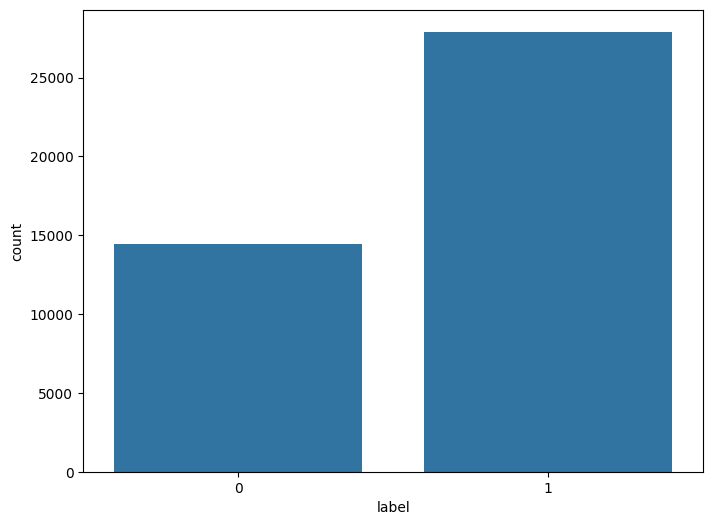

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x=data['label'])
plt.show()

## Pré-processamento de texto

Aqui, adentrando os dados textuais dentro da coluna `review`, iremos realizar a remoção de stop-words e lematização.

In [ ]:
stopwords_pt = stopwords.words("portuguese")

In [ ]:
stopwords_pt

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

As palavras 'não' e 'nem' são importantes para classificação negativa. Então é interessante removê-las das stopwords.

In [ ]:
stopwords_pt.remove('não')
stopwords_pt.remove('nem')

In [ ]:
def limpa_texto(texto):
  '''(str) -> str
  Essa funcao recebe uma string, deixa tudo em minusculo, filtra apenas letras,
  retira stopwords, lemmatiza e retorna a string resultante.
  '''
  texto = texto.lower()

  texto = re.sub(r"[\W\d_]+", " ", texto)

  texto = [pal for pal in texto.split() if pal not in stopwords_pt]

  spc_texto = spc_pt(" ".join(texto))
  tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in spc_texto]

  return " ".join(tokens)

Ao executar a função abaixo, há uma demora de 4mins.

Obs: No próprio *Kaggle* há bancos de dados maiores, entretanto, justamente quando chega-se nessa função, o tempo de demora é impraticável.

In [ ]:
data['review'] = data['review'].apply(limpa_texto)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42389 entries, 3 to 99223
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42389 non-null  object
 1   review_score            42389 non-null  int64 
 2   review_comment_title    42389 non-null  object
 3   review_comment_message  42389 non-null  object
 4   review                  42389 non-null  object
 5   label                   42389 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.3+ MB


In [ ]:
data.head(10)

,review_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,recebir bem antes prazo estipular,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,parabéns loja lannister adorar comprar Interne...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendar aparelho eficiente site marca apare...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travar valor ta boa,1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",super recomendar vendedor confiável produto ok...,1
16,9314d6f9799f5bfba510cc7bcd468c01,2,,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",gostar saber sempre recebir compra agora decpc...,0
19,373cbeecea8286a2b66c97b1b157ec46,1,Não chegou meu produto,Péssimo,não chegar produto péssimo,0
22,d21bbc789670eab777d27372ab9094cc,5,Ótimo,Loja nota 10,bom loja noto,1
24,0e0190b9db53b689b285d3f3916f8441,5,,obrigado pela atençao amim dispensada,obrigar atençao amim dispensar,1
27,fe3db7c069d694bab50cc43463f91608,5,,A compra foi realizada facilmente.\r\nA entreg...,compra realizar facilmente entregar efetuar an...,1


O pré-processamento de texto, pela própria remoção de stop-words, acaba por anular reviews inteiras. Assim, realizamos novamente o processo de remoção de reviews contendo apenas espaço em branco ' '.

In [ ]:
data[data['review'] == '']

,review_id,review_score,review_comment_title,review_comment_message,review,label
297,2b4a570df87cd63b232272dd9dcac0cf,5,,A,,1
463,3140a4eb146655fe104d54d385f9e9a0,5,,10,,1
583,3814f35a6ebd64d27e2130f30ec05255,4,5,,,1
598,057c9a1e8e767d8bf6fa59ac43a82435,4,4,,,1
939,8f965d010b3119d9962e091de3425fb9,4,,*******************,,1
...,...,...,...,...,...,...
94778,014f70270fa59804f14eb3df2ca690d2,5,,........................,,1
96770,47850e2adbd18f61f2af4af9b7656198,5,,👍🏻👌🏻👏🏻,,1
97441,e47fd0401fce7a7b6283da2a5a8ba563,5,10,,,1
98032,f004d8b3a2ff22e3c030285842cf629a,5,*****,,,1


In [ ]:
data = data[data['review'] != '']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42129 entries, 3 to 99223
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42129 non-null  object
 1   review_score            42129 non-null  int64 
 2   review_comment_title    42129 non-null  object
 3   review_comment_message  42129 non-null  object
 4   review                  42129 non-null  object
 5   label                   42129 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


## Modelos de Embeddings

A seguir iremos criar diferentes transformações de texto para vetores numéricos, chamados de *Embeddings*. Serão ao todo 4 transformações: Bag of words, TF-IDF, Word2Vec e Doc2Vec.

### Bag of Words

In [ ]:
# Instanciando o CountVectorizer, binary=True faz a codificacao binaria
vectorizer = CountVectorizer(binary=True, max_features=5000)

texto = data['review']

# Vetorizando o texto
X_bow = vectorizer.fit_transform(texto)

In [ ]:
X_bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
print(X_bow.shape, type(X_bow))

(42129, 5000) <class 'scipy.sparse._csr.csr_matrix'>


### TF-IDF

In [ ]:
# Instanciando o TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=5000)

# Vetorizando
X_tfidf = tfidf_vect.fit_transform(texto)

In [ ]:
print(X_tfidf)

  (0, 4030)	0.36902899295875535
  (0, 600)	0.4233886756107376
  (0, 291)	0.3487322838926013
  (0, 3652)	0.30194068419212955
  (0, 1860)	0.6868604291419556
  (1, 3368)	0.4365522023873557
  (1, 2748)	0.17044207211624518
  (1, 2646)	0.20412523190630272
  (1, 87)	0.2309024356906458
  (1, 1056)	0.16827622414828025
  (1, 2546)	0.3102644486142138
  (1, 4327)	0.30909851972592406
  (1, 3835)	0.3261617120041694
  (1, 4613)	0.21116173125763796
  (1, 2000)	0.3000912673788362
  (1, 3868)	0.47354018949641824
  (2, 4077)	0.12695584898537768
  (2, 307)	0.6542556117392547
  (2, 1627)	0.2085512451695864
  (2, 4391)	0.15066722659620096
  (2, 2849)	0.43714202571084987
  (2, 2412)	0.30533043095951695
  (2, 881)	0.09465087151599144
  (2, 3313)	0.14597055523425287
  (2, 3144)	0.23640596705572597
  :	:
  (42126, 143)	0.19026108145393103
  (42126, 2802)	0.2170491482818418
  (42126, 3571)	0.16508764788622662
  (42126, 2016)	0.2498643749130616
  (42126, 4818)	0.2391994850118754
  (42126, 1759)	0.2207082345198311

In [ ]:
X_tfidf.shape

(42129, 5000)

### Word2Vec

In [ ]:
# Tokenizar os textos para o Word2Vec
sentences = [review.split() for review in texto]

# Treinando o modelo Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
sentences

[['recebir', 'bem', 'antes', 'prazo', 'estipular'],
 ['parabéns',
  'loja',
  'lannister',
  'adorar',
  'comprar',
  'Internet',
  'seguro',
  'prático',
  'parabéns',
  'todo',
  'feliz',
  'Páscoa'],
 ['recomendar',
  'aparelho',
  'eficiente',
  'site',
  'marca',
  'aparelho',
  'impresso',
  'desinfector',
  'chegar',
  'outro',
  'nome',
  'atualizar',
  'marca',
  'correto',
  'vez',
  'aparelho'],
 ['pouco', 'travar', 'valor', 'ta', 'boa'],
 ['super',
  'recomendar',
  'vendedor',
  'confiável',
  'produto',
  'ok',
  'entregar',
  'antes',
  'prazo'],
 ['gostar', 'saber', 'sempre', 'recebir', 'compra', 'agora', 'decpcionar'],
 ['não', 'chegar', 'produto', 'péssimo'],
 ['bom', 'loja', 'noto'],
 ['obrigar', 'atençao', 'amim', 'dispensar'],
 ['compra',
  'realizar',
  'facilmente',
  'entregar',
  'efetuar',
  'antes',
  'prazo',
  'dar',
  'produto',
  'começar',
  'usar',
  'presente',
  'problema'],
 ['relógio', 'bonito', 'barato'],
 ['não', 'gostar', 'compr', 'gato', 'lebre'

In [ ]:
def get_average_embedding(tokens, model):
    # Pega os vetores das palavras presentes no modelo
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    # Retorna a média dos vetores ou um vetor nulo se nenhum token for encontrado
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Gerar embeddings para cada texto
X_w2vec = np.array([get_average_embedding(review.split(), word2vec_model) for review in texto])

In [ ]:
X_w2vec

array([[-0.2248509 ,  0.20289269, -0.11248283, ..., -0.74521244,
         0.39851287, -0.13675413],
       [-0.0922263 ,  0.89926934, -0.07091716, ..., -0.35450944,
         0.19017167,  0.25021473],
       [-0.25309438,  0.41635042,  0.29350507, ..., -0.14062035,
         0.39163437, -0.04968067],
       ...,
       [-0.04757736,  0.50512826,  0.56415755, ..., -0.33006796,
         0.18922056,  0.12981918],
       [-0.3235982 ,  0.8249124 , -0.16459997, ..., -0.45197427,
         0.1359071 , -0.03887188],
       [-0.09882306,  0.30088294,  0.5092154 , ..., -0.5074179 ,
         0.3566451 , -0.16678919]], dtype=float32)

In [ ]:
type(X_w2vec)

numpy.ndarray

In [ ]:
X_w2vec.shape

(42129, 100)

### Doc2Vec

In [ ]:
# Criando documentos etiquetados
documents = [TaggedDocument(words=review.split(), tags=[i]) for i, review in enumerate(data['review'])]

In [ ]:
documents

[TaggedDocument(words=['recebir', 'bem', 'antes', 'prazo', 'estipular'], tags=[0]),
 TaggedDocument(words=['parabéns', 'loja', 'lannister', 'adorar', 'comprar', 'Internet', 'seguro', 'prático', 'parabéns', 'todo', 'feliz', 'Páscoa'], tags=[1]),
 TaggedDocument(words=['recomendar', 'aparelho', 'eficiente', 'site', 'marca', 'aparelho', 'impresso', 'desinfector', 'chegar', 'outro', 'nome', 'atualizar', 'marca', 'correto', 'vez', 'aparelho'], tags=[2]),
 TaggedDocument(words=['pouco', 'travar', 'valor', 'ta', 'boa'], tags=[3]),
 TaggedDocument(words=['super', 'recomendar', 'vendedor', 'confiável', 'produto', 'ok', 'entregar', 'antes', 'prazo'], tags=[4]),
 TaggedDocument(words=['gostar', 'saber', 'sempre', 'recebir', 'compra', 'agora', 'decpcionar'], tags=[5]),
 TaggedDocument(words=['não', 'chegar', 'produto', 'péssimo'], tags=[6]),
 TaggedDocument(words=['bom', 'loja', 'noto'], tags=[7]),
 TaggedDocument(words=['obrigar', 'atençao', 'amim', 'dispensar'], tags=[8]),
 TaggedDocument(words=

In [ ]:
# Treinando o modelo Doc2Vec
model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=40)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
# Gerando embeddings para cada documento
X_d2vec = np.array([model.dv[i] for i in range(len(data))])
y_d2vec = data['label'].values

In [ ]:
X_d2vec

array([[ 0.03713657, -0.03291361, -0.08234597, ..., -0.03640286,
         0.09061285, -0.08350549],
       [ 0.19495735, -0.05839522, -0.09019012, ..., -0.29286647,
         0.4470435 , -0.02290541],
       [-0.20016874,  0.22336149, -0.49186227, ...,  0.14996944,
        -0.13013944, -0.4521947 ],
       ...,
       [ 0.51812035, -0.3088327 ,  0.02970285, ...,  0.38089055,
        -0.10495833,  0.15828419],
       [-0.09838074,  0.13147265, -0.06467134, ..., -0.02511782,
         0.04873461, -0.02356501],
       [ 0.14512938,  0.15855446,  0.06718323, ..., -0.22849064,
         0.07876989,  0.15291037]], dtype=float32)

In [ ]:
X_d2vec.shape

(42129, 100)

In [ ]:
y_d2vec.shape

(42129,)

Todos os embeddings correspondentes aos reviews gerados foram armazendos, respectivamente, nas matrizes `X_bow`, `X_tfidf`, `X_w2vec` e `X-d2vec`.

## Modelos de Classificação

Ao todo iremos comparar 4 modelos de classificação e verificar o de melhor acaurácia para usá-lo como modelo final do nosso projeto. São eles: Regressão Logística, Naive Bayes, Random Forest e K-NN.

Antes de tudo, iremos pegar todas as embeddings juntamente com os labels a elas relacionados e gerar dados de treinamento e teste através da divisão 70%-30%.

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_bow, data['label'],
                                                        test_size=0.3, random_state = 10)

X2_train, X2_test, y2_train, y2_test = train_test_split(X_tfidf, data['label'],
                                                        test_size=0.3, random_state = 10)

X3_train, X3_test, y3_train, y3_test = train_test_split(X_w2vec, data['label'],
                                                        test_size=0.3, random_state = 10)

X4_train, X4_test, y4_train, y4_test = train_test_split(X_d2vec, data['label'],
                                                        test_size=0.3, random_state = 10)

Para avaliação de modelos de classificação iremos utilizar Acurácia, área da Curva ROC, F1-Score e Matriz de Confusão

In [ ]:
def mostra_metricas(y_true, y_pred):
  ''' Função que recebe o y real, o y predito e mostra as
  principais metricas.
  '''
  print("Acurácia: ", accuracy_score(y_true, y_pred))


  print("\nAUROC:", roc_auc_score(y_true, y_pred))
  print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
  print("\nMatriz de confusão:")
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
  plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

### Regressão Logísitica

In [ ]:
# Instanciando a reg. logistica
reglog = LogisticRegression()

# Aplicando o modelo
reglog.fit(X1_train, y1_train)

LogisticRegression()

In [ ]:
# Predicao
y1_reglog_pred = reglog.predict(X1_test)

Acurácia:  0.8930295118284675

AUROC: 0.8767175505035738

F1-Score: 0.8924763683576222

Matriz de confusão:


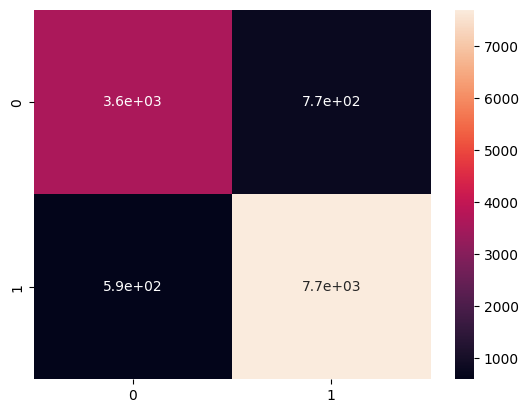

In [ ]:
mostra_metricas(y1_test, y1_reglog_pred)

Acurácia:  0.8956404778859087

AUROC: 0.8829519285666818

F1-Score: 0.8954758574959791

Matriz de confusão:


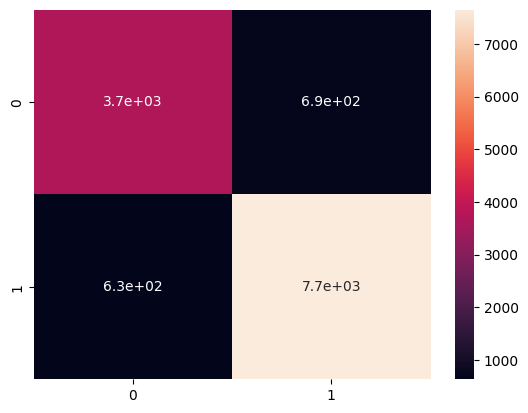

In [ ]:
reglog2 = LogisticRegression()

reglog2.fit(X2_train, y2_train)

y2_reglog_pred = reglog2.predict(X2_test)

mostra_metricas(y2_test, y2_reglog_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acurácia:  0.879579080623467

AUROC: 0.8674876624907294

F1-Score: 0.8796699775314002

Matriz de confusão:


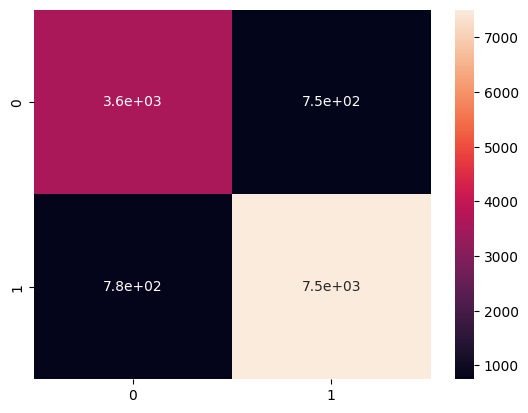

In [ ]:
reglog3 = LogisticRegression()

reglog3.fit(X3_train, y3_train)

y3_reglog_pred = reglog3.predict(X3_test)

mostra_metricas(y3_test, y3_reglog_pred)

Acurácia:  0.8317113695703774

AUROC: 0.8021381043930174

F1-Score: 0.8294903353035199

Matriz de confusão:


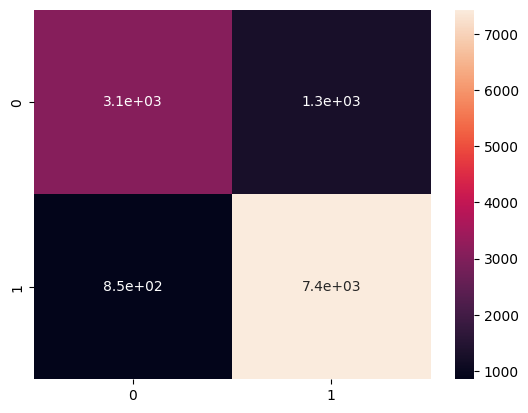

In [ ]:
reglog4 = LogisticRegression()

reglog4.fit(X4_train, y4_train)

y4_reglog_pred = reglog4.predict(X4_test)

mostra_metricas(y4_test, y4_reglog_pred)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

### Naive Bayes

Acurácia:  0.8904185457710262

AUROC: 0.8819586121243606

F1-Score: 0.8907602187991185

Matriz de confusão:


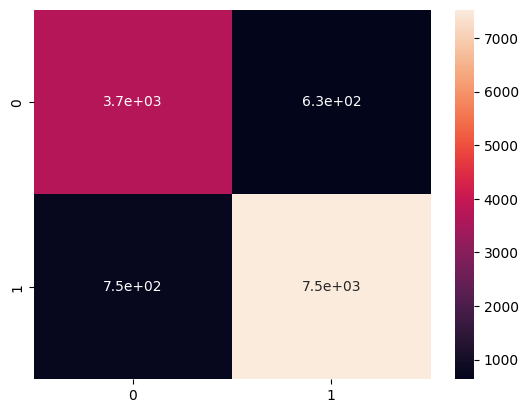

In [ ]:
nb1 = MultinomialNB()

nb1.fit(X1_train.toarray(), y1_train)

y1_gnb_pred = nb1.predict(X1_test.toarray())

mostra_metricas(y1_test, y1_gnb_pred)

Acurácia:  0.8905767861381438

AUROC: 0.8798495311333558

F1-Score: 0.8906798062734013

Matriz de confusão:


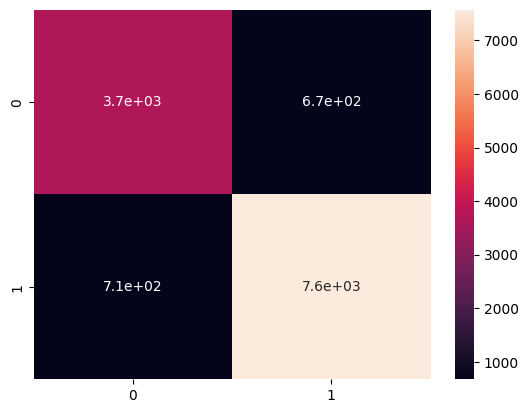

In [ ]:
nb2 = MultinomialNB()

nb2.fit(X2_train.toarray(), y2_train)

y2_gnb_pred = nb2.predict(X2_test.toarray())

mostra_metricas(y2_test, y2_gnb_pred)

Acurácia:  0.8635968035445842

AUROC: 0.8361486790763304

F1-Score: 0.8615709360988554

Matriz de confusão:


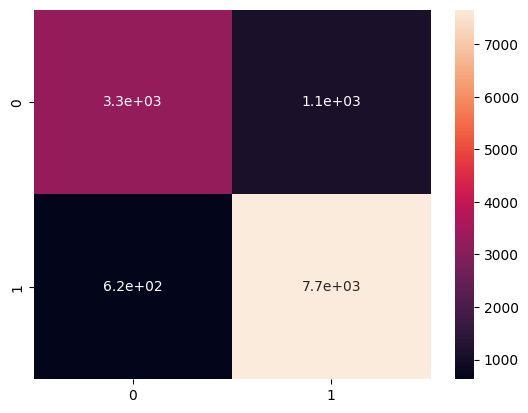

In [ ]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
X3_train_scaled = scaler.fit_transform(X3_train)

# Transform the test data using the fitted scaler
X3_test_scaled = scaler.transform(X3_test)

# Now, use the scaled data for training the MultinomialNB model
nb3 = MultinomialNB()
nb3.fit(X3_train_scaled, y3_train)

# Make predictions using the scaled test data
y3_gnb_pred = nb3.predict(X3_test_scaled)

# Evaluate the model
mostra_metricas(y3_test, y3_gnb_pred)

Acurácia:  0.6552733602341957

AUROC: 0.5

F1-Score: 0.518806363888878

Matriz de confusão:


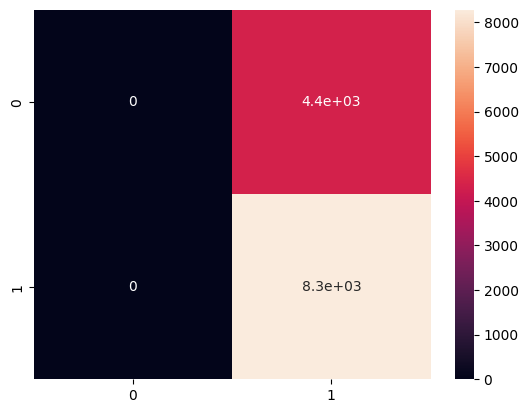

In [ ]:
#from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
X4_train_scaled = scaler.fit_transform(X4_train)

# Transform the test data using the fitted scaler
X4_test_scaled = scaler.transform(X4_test)

# Now, use the scaled data for training the MultinomialNB model
nb4 = MultinomialNB()
nb4.fit(X4_train_scaled, y4_train)

# Make predictions using the scaled test data
y4_gnb_pred = nb4.predict(X4_test_scaled)

# Evaluate the model
# mostra_metricas_novo(y4_test, y4_gnb_pred)
mostra_metricas(y4_test, y4_gnb_pred)

### Random Forest

Acurácia:  0.8905767861381438

AUROC: 0.8819705839659241

F1-Score: 0.8909013763151656

Matriz de confusão:


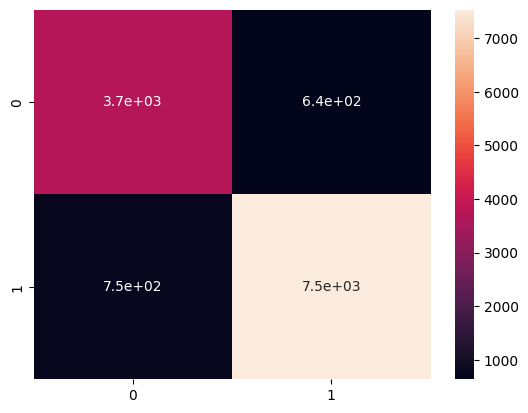

In [ ]:
rf1 = RandomForestClassifier()

rf1.fit(X1_train, y1_train)

y1_dt_pred = rf1.predict(X1_test)

mostra_metricas(y1_test, y1_dt_pred)

Acurácia:  0.8908141466888203

AUROC: 0.881390296057545

F1-Score: 0.8910514782406309

Matriz de confusão:


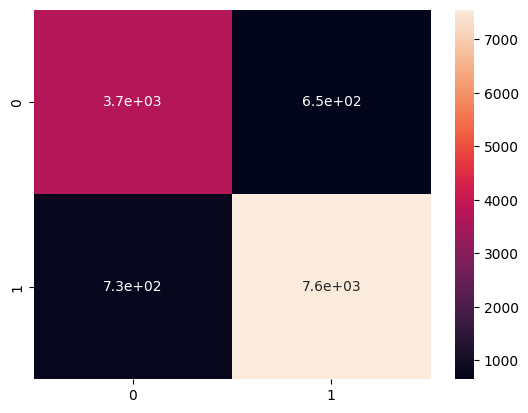

In [ ]:
rf2 = RandomForestClassifier()

rf2.fit(X2_train, y2_train)

y2_dt_pred = rf2.predict(X2_test)

mostra_metricas(y2_test, y2_dt_pred)

Acurácia:  0.8862251760424085

AUROC: 0.8741904804239051

F1-Score: 0.8862375362512478

Matriz de confusão:


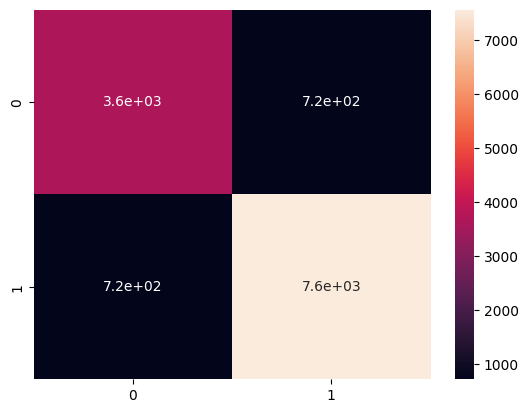

In [ ]:
rf3 = RandomForestClassifier()

rf3.fit(X3_train, y3_train)

y3_dt_pred = rf3.predict(X3_test)

mostra_metricas(y3_test, y3_dt_pred)

Acurácia:  0.8510958145422898

AUROC: 0.8357467632934691

F1-Score: 0.8511762975559668

Matriz de confusão:


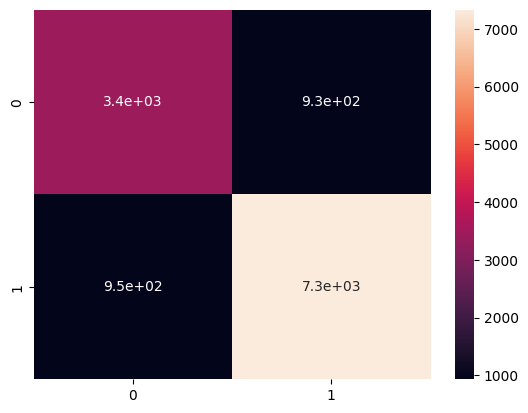

In [ ]:
rf4 = RandomForestClassifier()

rf4.fit(X4_train, y4_train)

y4_dt_pred = rf4.predict(X4_test)

mostra_metricas(y4_test, y4_dt_pred)

## K-NN

Acurácia:  0.8653374475828783

AUROC: 0.8365522991838584

F1-Score: 0.86306464821698

Matriz de confusão:


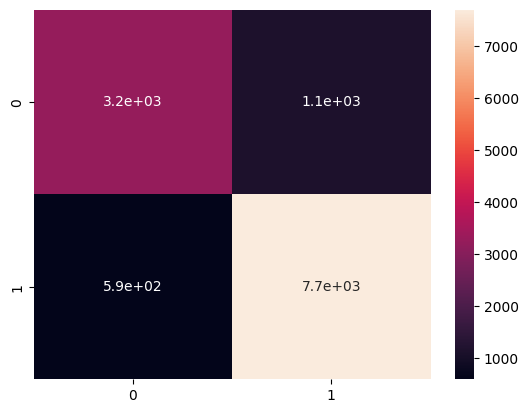

In [ ]:
knn1=KNeighborsClassifier(n_neighbors=3, metric='euclidean')

knn1.fit(X1_train, y1_train)  # Treinamento
y1_nn_pred = knn1.predict(X1_test)  # Previsões
mostra_metricas(y1_test, y1_nn_pred)

Acurácia:  0.7717382704327874

AUROC: 0.6932884858541329

F1-Score: 0.7502182453242461

Matriz de confusão:


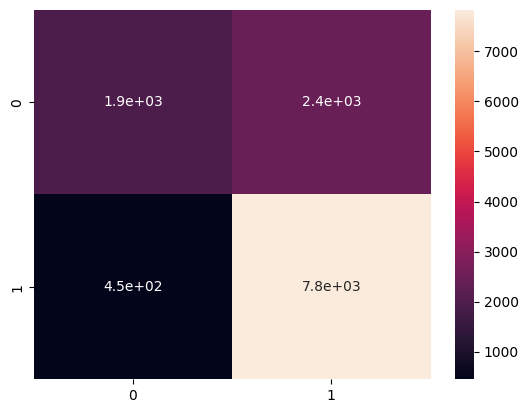

In [ ]:
knn2=KNeighborsClassifier(n_neighbors=3, metric='euclidean')

knn2.fit(X2_train, y2_train)  # Treinamento
y2_nn_pred = knn2.predict(X2_test)  # Previsões
mostra_metricas(y2_test, y2_nn_pred)

Acurácia:  0.871429701716908

AUROC: 0.8589851469906586

F1-Score: 0.8715916444501784

Matriz de confusão:


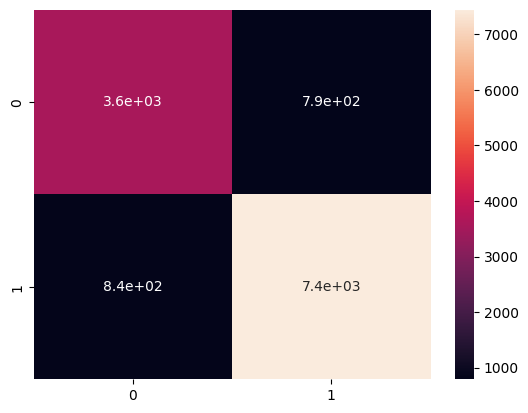

In [ ]:
knn3=KNeighborsClassifier(n_neighbors=3, metric='euclidean')

knn3.fit(X3_train, y3_train)  # Treinamento
y3_nn_pred = knn3.predict(X3_test)  # Previsões
mostra_metricas(y3_test, y3_nn_pred)

Acurácia:  0.8201598227707888

AUROC: 0.7783132805910896

F1-Score: 0.8149610543763096

Matriz de confusão:


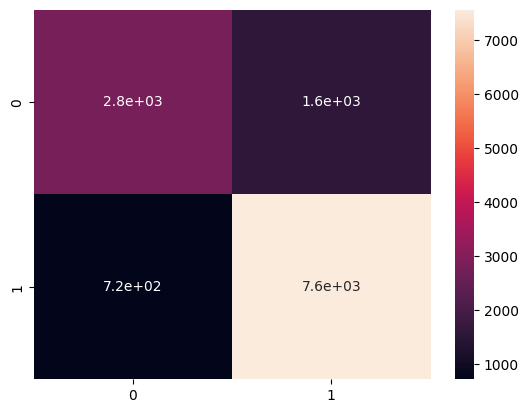

In [ ]:
knn4=KNeighborsClassifier(n_neighbors=3, metric='euclidean')

knn4.fit(X4_train, y4_train)  # Treinamento
y4_nn_pred = knn4.predict(X4_test)  # Previsões
mostra_metricas(y4_test, y4_nn_pred)

O pior caso apresentado foi o modelo de classificação Naive Bayes para embbeding Doc2Vec. Alias, na maioria dos modelos de classificação (à exceção do K-NN) o embbeding Doc2Vec apresentou sempre o pior desempenho.

Todos os outros embbedings apresentaram métricas de desempenho relativamente próximas. Entretanto, o melhor caso foi o da Regressão Logísitica aplicado a embbeding TF-IDF, apresentando o maior valor de acurácia.

## Modelo Final de Análise de Sentimento

Conforme os experimentos anteriores, selecionamos a classificação por Regressão Logística utilizando embedding TF-IDF análise de sentimentos positivo e negativo, realizada na função abaixo.

In [ ]:
def nova_predicao(texto):
  '''Funcao que recebe uma string e printa a pedicao feita
  pelo modelo reglog2.'''
  texto_vetorizado = tfidf_vect.transform([texto])
  pred = reglog2.predict(texto_vetorizado)

  if pred == 0:
    print("Essa é uma review negativa.")
  else:
    print("Essa é uma review positiva.")

In [ ]:
nova_predicao("Impressionante a quantidade de tempo perdido")

Essa é uma review negativa.


In [ ]:
nova_predicao("Melhor que isso seria não ter pedido mesmo.")

Essa é uma review negativa.


In [ ]:
nova_predicao("Muito bom")

Essa é uma review positiva.


Entretanto, como é de se esperar pela utilização de um banco de dados de comentários sobre produtos, o atual modelo não é capaz de entender ironias.

In [ ]:
nova_predicao("Desprovido de negatividade")

Essa é uma review negativa.


Algumas limitações de vocabulário também são encontradas. O que demonstra a necessidade de melhor treinamento.

In [ ]:
nova_predicao("Provido de positividade")

Essa é uma review negativa.


In [ ]:
nova_predicao("gostei")

Essa é uma review positiva.


Frases neutras possuem uma zona nebulosa de classificação, conforme esperado.

In [ ]:
nova_predicao("mais ou menos")

Essa é uma review positiva.


In [ ]:
nova_predicao("Dá pro gasto")

Essa é uma review positiva.


In [ ]:
nova_predicao("Melhor que nada ")

Essa é uma review negativa.


O avaliador pode se sentir à vontade de rodar outros exemplos: